# DrugComb Analysis

Analyzing drug combinations' efficacy on cancer cell treatment.


## ZIP SYNERGY SCORE

In [1]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import networkx as nx
import chardet
import matplotlib.pyplot as plt
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from node2vec import Node2Vec

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DATA PREPROCESSING

Read the data from the files and show the first 5 rows of the data.

In [4]:
#path_combinations = './data/Syner&Antag_voting.csv'
path_combinations = '/content/drive/My Drive/INA/data/Syner&Antag_voting.csv'

# load main data
df_combinations = pd.read_csv(path_combinations)

In [5]:
# show the first 5 rows of the data
print(df_combinations.head())

# show dimensions of the data
print(df_combinations.shape)

   ID Drug1    Drug2 Cell line    ZIP  Bliss  Loewe    HSA  ZIPclassification  \
0   1  5-FU  ABT-888     A2058   5.88  12.33   3.33  11.61                  1   
1   2  5-FU  ABT-888     A2058   3.59  11.66   2.65  10.94                  1   
2   3  5-FU  AZD1775     A2058  12.29  15.77  10.40  18.66                  1   
3   4  5-FU  AZD1775     A2058   7.64   6.52   1.15   9.41                  1   
4   5  5-FU  AZD1775     A2058  14.79  15.18   9.81  18.07                  1   

   blissclassification  loeweclassification  hsaclassification  synthetic  \
0                    1                    1                  1          4   
1                    1                    1                  1          4   
2                    1                    1                  1          4   
3                    1                    1                  1          4   
4                    1                    1                  1          4   

  classification  
0        synergy  
1        syn

In [6]:
# are there any missing values?
print(df_combinations.isnull().sum())

# remove rows with missing values
df_combinations = df_combinations.dropna()

# how many rows are left?
print(df_combinations.shape)

ID                     0
Drug1                  1
Drug2                  1
Cell line              0
ZIP                    0
Bliss                  0
Loewe                  1
HSA                    0
ZIPclassification      0
blissclassification    0
loeweclassification    0
hsaclassification      0
synthetic              0
classification         0
dtype: int64
(240973, 14)


Similarly to the original article decide the threshold for synergy and antagonism on each metric.
Upper 25% of the scores are considered as synergy, lower 25% as antagonism, and the rest as no effect / not sure.

In [7]:
'''
# Z-SCORES:
# ZIP z-score thresholds
zip_threshold_synergy = df_combinations['ZIP_zscore'].quantile(0.75)
zip_threshold_antagonism = df_combinations['ZIP_zscore'].quantile(0.25)

# Bliss z-score thresholds
bliss_threshold_synergy = df_combinations['BLISS_zscore'].quantile(0.75)
bliss_threshold_antagonism = df_combinations['BLISS_zscore'].quantile(0.25)

# HSA z-score thresholds
hsa_threshold_synergy = df_combinations['HSA_zscore'].quantile(0.75)
hsa_threshold_antagonism = df_combinations['HSA_zscore'].quantile(0.25)

# Loewe z-score thresholds
loewe_threshold_synergy = df_combinations['Loewe_zscore'].quantile(0.75)
loewe_threshold_antagonism = df_combinations['Loewe_zscore'].quantile(0.25)

# print the thresholds
print(f'ZIP z-score thresholds: synergy {zip_threshold_synergy}, antagonism {zip_threshold_antagonism}')
print(f'Bliss z-score thresholds: synergy {bliss_threshold_synergy}, antagonism {bliss_threshold_antagonism}')
print(f'HSA z-score thresholds: synergy {hsa_threshold_synergy}, antagonism {hsa_threshold_antagonism}')
print(f'Loewe z-score thresholds: synergy {loewe_threshold_synergy}, antagonism {loewe_threshold_antagonism}')
'''

# original scores thresholds
zip_threshold_synergy = df_combinations['ZIP'].quantile(0.75)
zip_threshold_antagonism = df_combinations['ZIP'].quantile(0.25)

bliss_threshold_synergy = df_combinations['Bliss'].quantile(0.75)
bliss_threshold_antagonism = df_combinations['Bliss'].quantile(0.25)

hsa_threshold_synergy = df_combinations['HSA'].quantile(0.75)
hsa_threshold_antagonism = df_combinations['HSA'].quantile(0.25)

loewe_threshold_synergy = df_combinations['Loewe'].quantile(0.75)
loewe_threshold_antagonism = df_combinations['Loewe'].quantile(0.25)

# print the thresholds
print(f'ZIP thresholds: synergy {zip_threshold_synergy}, antagonism {zip_threshold_antagonism}')
print(f'Bliss thresholds: synergy {bliss_threshold_synergy}, antagonism {bliss_threshold_antagonism}')
print(f'HSA thresholds: synergy {hsa_threshold_synergy}, antagonism {hsa_threshold_antagonism}')
print(f'Loewe thresholds: synergy {loewe_threshold_synergy}, antagonism {loewe_threshold_antagonism}')

ZIP thresholds: synergy 2.84, antagonism -6.73
Bliss thresholds: synergy 4.06, antagonism -6.68
HSA thresholds: synergy 5.14, antagonism -5.0
Loewe thresholds: synergy 2.8, antagonism -11.63


## GRAPH CREATION AND NETWORK ANALYSIS

DONE: Create a subgraph for every cell line and calculate network statistics for each subgraph.

In [8]:
#print(df_combinations.head())
# are there rows with same Drug1, Drug2 but different cell lines?
grouped = df_combinations.groupby(['Drug1', 'Drug2'])['Cell line'].nunique().reset_index(name='count')
print(len(grouped[grouped['count'] > 1]))

7858


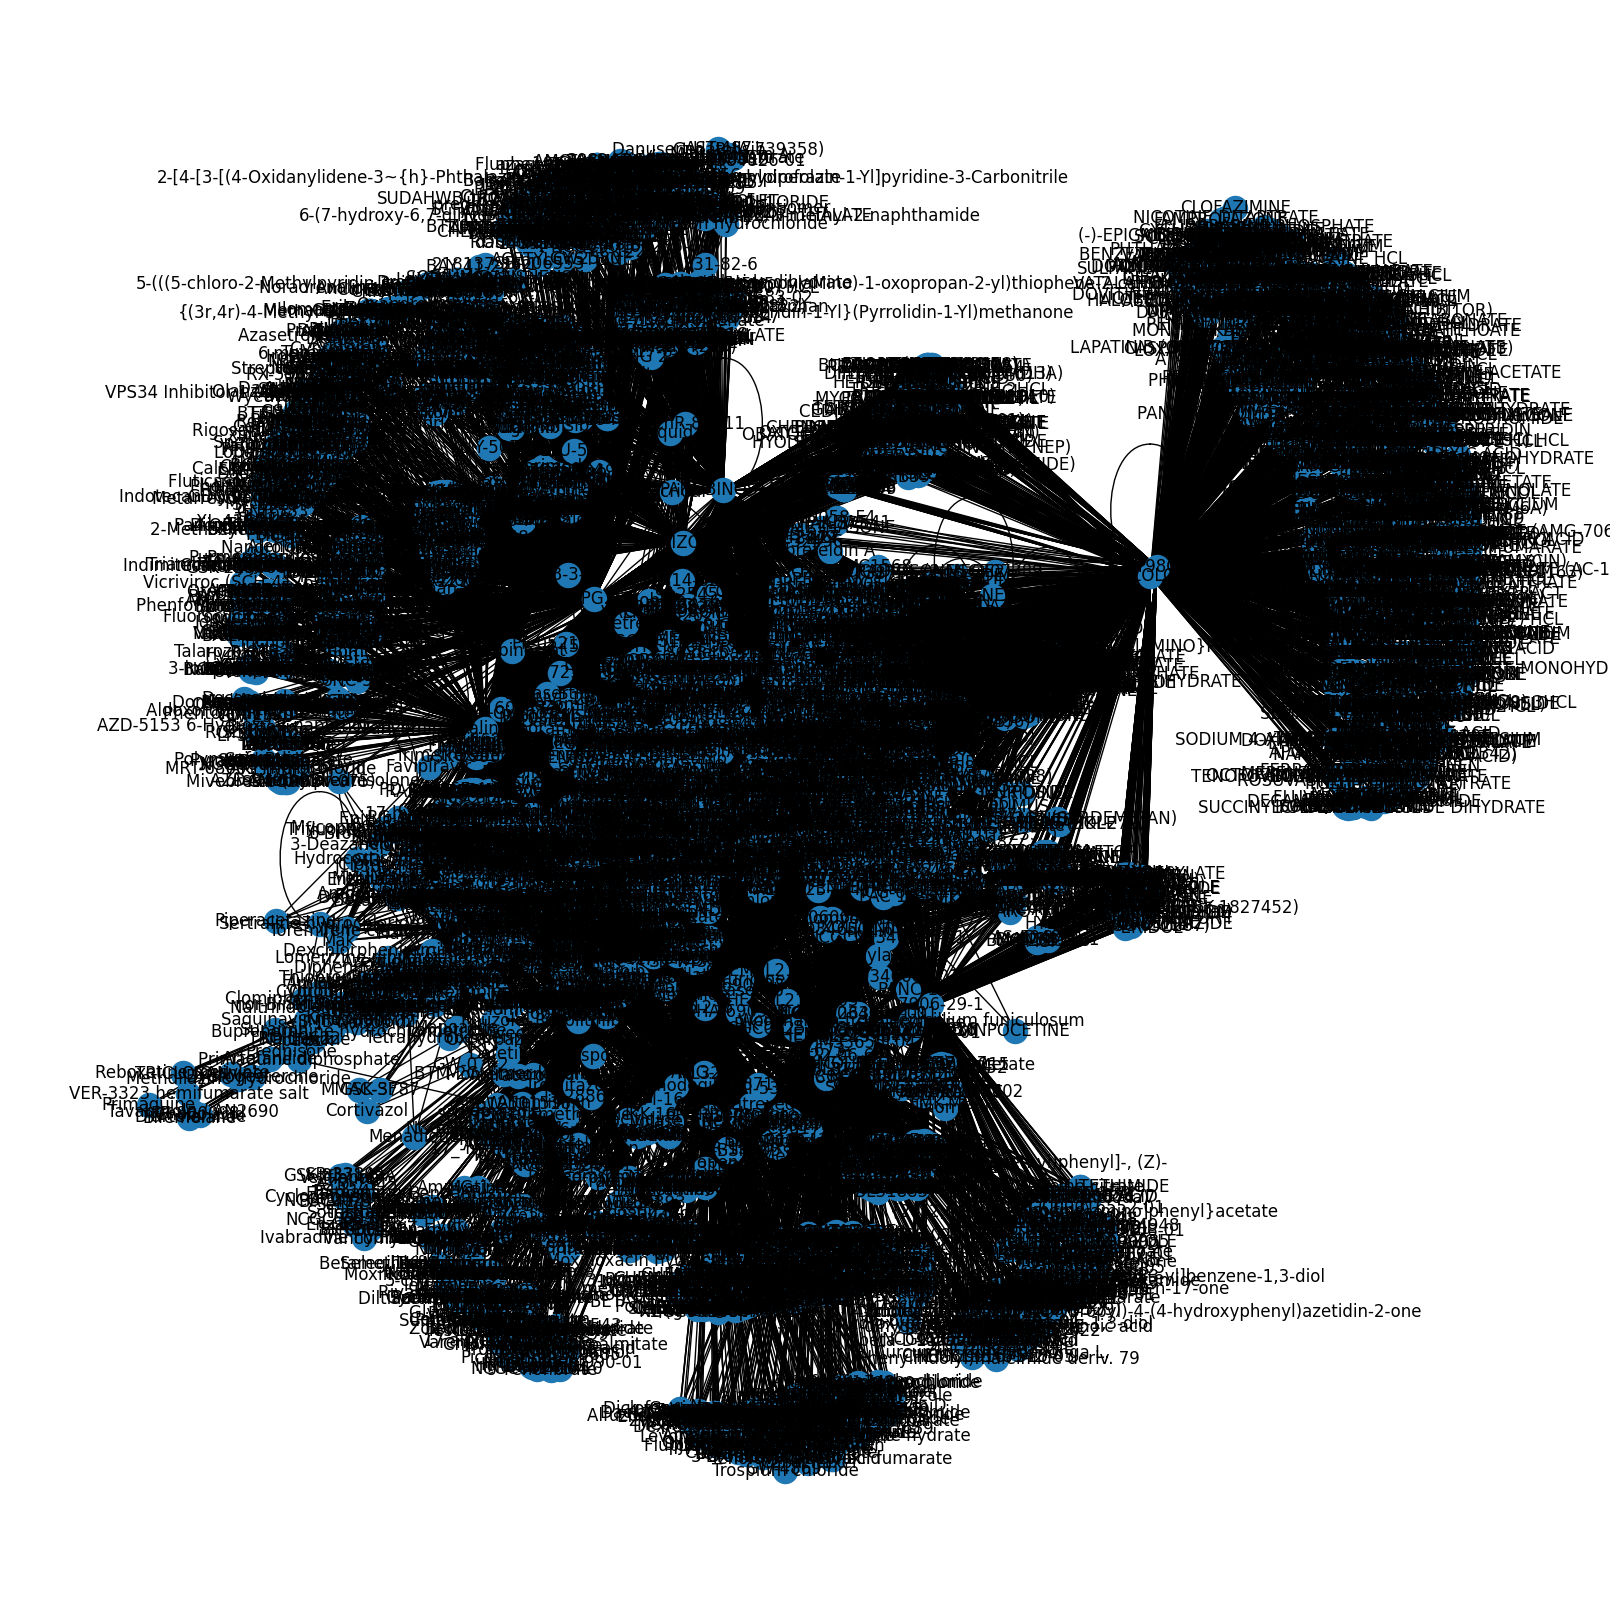

In [9]:
# initialize graph
G = nx.Graph()

# populate graph with nodes and edges

# nodes are drugs and cells
for i, row in df_combinations.iterrows():
    G.add_node(row['Drug1'], type='drug')
    G.add_node(row['Drug2'], type='drug')

    G.add_node(row['Cell line'], type='cell')

# add edges for combinations
for i, row in df_combinations.iterrows():
    G.add_edge(row['Drug1'], row['Drug2'], type='combination')

# add edges for interactions
for i, row in df_combinations.iterrows():
    G.add_edge(row['Drug1'], row['Cell line'], type='interaction')
    G.add_edge(row['Drug2'], row['Cell line'], type='interaction')

# visualize the graph
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True)
plt.show()

Convert the graph using Node2Vec and visualize the embeddings.

In [10]:
# convert the graph to node2vec format
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# train the model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# get the embeddings
drug1_embedding = model.wv['Drug1']
drug2_embedding = model.wv['Drug2']
cell_embedding = model.wv['Cell line']

# visualize the embeddings
plt.scatter(drug1_embedding, drug2_embedding)
plt.show()

Computing transition probabilities:   0%|          | 0/4776 [00:00<?, ?it/s]

KeyError: "Key 'Drug1' not present"

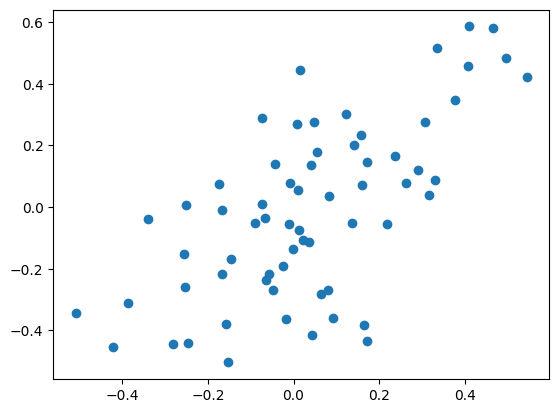

In [13]:
# Example: Get the embeddings for actual nodes in your graph
example_drug1 = df_combinations.iloc[0]['Drug1']
example_drug2 = df_combinations.iloc[0]['Drug2']
example_cell = df_combinations.iloc[0]['Cell line']

# Get the embeddings
drug1_embedding = model.wv[example_drug1]
drug2_embedding = model.wv[example_drug2]
cell_embedding = model.wv[example_cell]

# Visualize the embeddings
plt.scatter(drug1_embedding, drug2_embedding)
plt.show()

## MACHINE LEARNING MODEL
First prepare the data for the machine learning model.

In [14]:
# Function to get embeddings for a combination
def get_combined_embedding(row, model):
    drug1_emb = model.wv[row['Drug1']]
    drug2_emb = model.wv[row['Drug2']]
    cell_emb = model.wv[row['Cell line']]
    return np.concatenate((drug1_emb, drug2_emb, cell_emb))

# Create feature matrix X and target vector y
X = np.array(df_combinations.apply(lambda row: get_combined_embedding(row, model), axis=1).tolist())
y = df_combinations['ZIP'].values  # or the respective synergy/antagonism metric

In [15]:
print(X.shape)
print(y.shape)

(240973, 192)
(240973,)


In [16]:
X

array([[-0.04783105,  0.01567863,  0.06380136, ..., -0.05759711,
        -0.17747815, -0.09792262],
       [-0.04783105,  0.01567863,  0.06380136, ..., -0.05759711,
        -0.17747815, -0.09792262],
       [-0.04783105,  0.01567863,  0.06380136, ..., -0.05759711,
        -0.17747815, -0.09792262],
       ...,
       [-0.12342361,  0.09793863, -0.6283256 , ..., -0.17148383,
         0.08019838,  0.30607656],
       [-0.5486553 , -0.1918962 , -1.0101353 , ..., -0.17148383,
         0.08019838,  0.30607656],
       [-0.38402566,  0.18023339, -0.5830037 , ...,  0.3831566 ,
         0.26417783,  0.5780598 ]], dtype=float32)

Split the data into training and testing sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# show dimensions of the data
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}, y_zip_test: {y_test.shape}')

X_train: (192778, 192), X_test: (48195, 192)
y_train: (192778,), y_zip_test: (48195,)


Normalize the features.

In [ ]:
#scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

Now train different machine learning models to predict the efficacy of drug combinations

In [18]:
# import necessary libraries for models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

Linear regression model

BUG-FIX: y_zip_train is a pandas series, but it should be a numpy array, witout indexes

In [ ]:
#y_zip_train = y_train.to_numpy().reshape(-1, 1)

#y_zip_test = y_test.to_numpy().reshape(-1, 1).ravel()

In [19]:
# show dimensions of the data
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'y_zip_train: {y_train.shape}, y_zip_test: {y_test.shape}')

X_train: (192778, 192), X_test: (48195, 192)
y_zip_train: (192778,), y_zip_test: (48195,)


In [49]:
# linear regression model
model_zip = LinearRegression()
model_zip.fit(X_train, y_train)
y_pred = model_zip.predict(X_test)
mse_zip = mean_squared_error(y_test, y_pred)
print('MSE ZIP:', mse_zip)

# get linear model's coefficients to show most important features
coefficients_zip = model_zip.coef_

# sort coefficients
coefficients_zip = np.argsort(coefficients_zip)

# show the most important features
print('ZIP:', coefficients_zip[:7])

MSE ZIP: 7747575.97886373
ZIP: [ 74  83 106  90  79  94 116]


Random forest model

In [48]:
# random forest model
model_zip = RandomForestRegressor()
model_zip.fit(X_train, y_train)
y_pred_new = model_zip.predict(X_test)
mse_zip = mean_squared_error(y_test, y_pred)
print('MSE ZIP:', mse_zip)

KeyboardInterrupt: 

Predict New Combinations

In [25]:
# Define the new combination
new_combination = {'Drug1': '5-FU', 'Drug2': 'ABT-888', 'Cell line': 'A2058'}

# Ensure these new drugs and cell line are present in the original graph embeddings
if all(node in model.wv for node in [new_combination['Drug1'], new_combination['Drug2'], new_combination['Cell line']]):
    # Get the combined embedding
    new_combination_embedding = get_combined_embedding(new_combination, model).reshape(1, -1)

    # Predict using the trained model
    predicted_zip = model_zip.predict(new_combination_embedding)
    print(f'Predicted ZIP value: {predicted_zip[0]}')
else:
    print("One or more nodes are not present in the trained Node2Vec model.")


Predicted ZIP value: 4.466555


In [45]:
#max(y_pred)
#min(y_pred)

min = 0
min_i = 0
max = 0
max_i = 0

count = 0

y_test_copy = y_test.copy()
y_pred_copy = y_pred.copy()

y_pred.shape
for i in range(48195):
  #print(f'{i}: {y_pred[i]:.2f}')

  if (np.abs(y_pred[i]) > 50):
    print(f'{i}: {y_pred[i]:.2f}')
    count += 1

    # remove from y_pred_copy
    y_pred_copy = np.delete(y_pred_copy, i)
    y_test_copy = np.delete(y_test_copy, i)

  if (min > y_pred[i]):
    min = y_pred[i]
    min_i = i
  if (max < y_pred[i]):
    max = y_pred[i]
    max_i = i

print(f'min: {min} at i: {min_i}')
print(f'max: {max} at i: {max_i}')
print(f'count: {count}')


mse_without_large_values =  mean_squared_error(y_test_copy, y_pred_copy)
print(f'mse after large value removeal: {mse_without_large_values}')

440: 190149.47
614: 84.10
640: 188.30
1398: 1238.92
1444: 22036.94
1987: 62.66
1991: 1742.37
2034: 124.59
2115: 519.27
2240: 131.90
2543: 55.77
2606: 51.11
2915: 15660.53
3334: -13000.85
3652: 54.53
4009: 517.40
4186: -16168.25
4218: 53.58
4296: 2389.94
4654: 118.69
4810: 65.27
5374: 866.35
6733: 582.58
6894: 793.86
7118: 303.56
7535: 5021.07
7583: 55.75
7765: 9889.75
7810: 10976.14
8404: 64.75
8480: 83.98
9437: 98130.92
9568: 37081.31
9690: 88725.28
9870: 5219.75
10111: 1493.58
10505: 223.54
10587: 50.09
10595: 1447.49
10731: 331.04
11114: 167924.89
11340: -28160.12
11438: 57.66
11939: 93.02
11977: 50701.10
12414: 8227.73
13028: -4334.02
13111: 127.13
13233: 133.91
13851: 4225.12
14212: -4714.44
14256: 1474.14
14420: 88.75
14497: 204.93
15054: 8229.88
15205: 9890.94
15570: 4003.19
15751: 355228.43
15828: 266.07
15831: 4003.26
16060: 2607.92
16333: 59.18
16363: 62.34
16522: 2367.52
17479: 139.81
17599: 28905.79
17697: 786.85
18407: 98.07
18919: 315.23
19736: -28132.66
20213: 115.11
203

In [53]:
correct_classification = 0

for i in range(len(y_pred)):
  if ((y_pred[i] > 0 and y_test[i] > 0) or (y_pred[i] < 0 and y_test[i] < 0)):
    correct_classification += 1
  else:
    wrong_classification += 1
    print(f'predicted: {y_pred[i]:.2f}, gt: {y_test[i]}')

print(F'Prediction accuracy: {correct_classification/len(y_pred)}')

Izpis pretočnega predvajanja je skrajšan na toliko zadnjih vrstic: 5000.
predicted: -0.33, gt: 3.477
predicted: -4.21, gt: 0.91
predicted: 2.29, gt: -1.8
predicted: -0.40, gt: 6.46
predicted: -3.61, gt: 1.74
predicted: 1.33, gt: -4.923
predicted: 0.82, gt: -3.7
predicted: -1.50, gt: 3.37
predicted: -0.38, gt: 1.94
predicted: -1.00, gt: 6.801
predicted: 1.23, gt: -3.16
predicted: -11.70, gt: 19.29
predicted: -2.23, gt: 4.54
predicted: 2.28, gt: -0.39
predicted: -10.08, gt: 45.52
predicted: 2.79, gt: -0.85
predicted: -16.06, gt: 23.31
predicted: -2.03, gt: 1.81
predicted: -0.58, gt: 3.59
predicted: -4.49, gt: 5.37
predicted: 0.68, gt: -7.52
predicted: 1.35, gt: -5.13
predicted: -0.86, gt: 5.45
predicted: 1.87, gt: -0.44
predicted: 0.42, gt: -1.42
predicted: -4.25, gt: 2.13
predicted: -5.54, gt: 1.08
predicted: -3.79, gt: 2.21
predicted: -3.88, gt: 3.43
predicted: 0.35, gt: -38.1
predicted: 0.42, gt: -1.45
predicted: -21.88, gt: 0.13
predicted: -1.34, gt: 9.49
predicted: -0.28, gt: 4.88
p